In [1]:
%cd ..
%load_ext autoreload
%autoreload 2
import sensor_lib as sl

/home/jovyan/RQC-Robotics-tactile_sensor


In [2]:
%load_ext tensorboard

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import yaml

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
geo = config['env']['sen_geometry']
phys = config['env']['phys']

In [5]:
np.random.seed(config['random_seed'])
seeds = np.random.randint(0, 2**32, size=3)

# generation pressure_map

In [6]:
x = geo['x_len']
y = geo['y_len']
n_pic = config['dataset']['n_sampels']
n_gaus = config['env']['presure_profile']['n_gauses']
size_kof = config['env']['presure_profile']['size_kof']
vec_mat = tf.constant(sl.get_vec_mat(x, y), dtype=tf.float32)
vec_mat = tf.reshape(vec_mat, [-1, 2])
gaus_data = sl.gen_rand_cof(n_gaus * n_pic, x, y, size_kof,
                            seed=seeds[0])  # use random inside
gaus_data = tf.reshape(gaus_data, [n_pic, n_gaus, 5])
with open(config['env']['presure_profile']['g_param_path'], 'wb+') as f:
    np.save(f, gaus_data)

2022-05-28 13:05:37.200614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 13:05:38.064952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30982 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0


In [11]:
dataset = tf.data.Dataset.from_tensor_slices(gaus_data)
batches = dataset.batch(100, drop_remainder=False)

In [12]:
tf.profiler.experimental.start('logs')
pictures=[]
for batch in batches:
    picture = sl.generate_pictures(batch, vec_mat)
    pictures.append(picture)
tf.profiler.experimental.stop()
pictures = tf.concat(pictures, axis=0)
pictures = tf.reshape(pictures, [n_pic, x, y])

2022-05-28 13:08:16.325680: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-05-28 13:08:16.325726: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-05-28 13:08:16.325837: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs


2022-05-28 13:08:20.630658: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-28 13:08:20.632487: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-05-28 13:08:20.665712: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 182 callback api events and 182 activity events. 
2022-05-28 13:08:20.675002: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-05-28 13:08:20.696349: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022_05_28_13_08_20

2022-05-28 13:08:20.712883: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/plugins/profile/2022_05_28_13_08_20/309a475ad849.trace.json.gz
2022-05-28 13:08:20.725842: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/plugins/profile/2022_0

In [11]:
# writer = tf.summary.create_file_writer('logs')
# tf.summary.trace_on(graph=True, profiler=True)
# pic = sl.generate_multi_gaussian_flat(gaus_data[0], vec_mat)
# with writer.as_default():
#     tf.summary.trace_export(
#       name="multi_gaussian_trace",
#       step=0,
#       profiler_outdir='logs')

2022-05-28 12:41:12.550064: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-05-28 12:41:12.550131: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-05-28 12:41:12.762867: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-28 12:41:12.766110: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-05-28 12:41:12.799107: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 30 callback api events and 29 activity events. 
2022-05-28 12:41:12.800786: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


In [21]:
pictures.shape

TensorShape([2000, 64, 64])

limit by hat fun

In [13]:
norm = sl.round_fun([x, y], [x / 2, y / 2], lambda l: sl.hat(l, x / 2))
pictures = pictures * norm

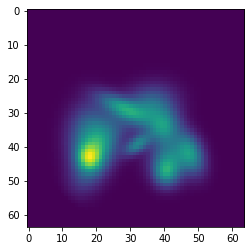

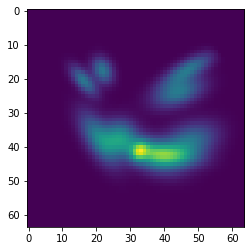

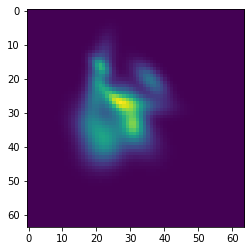

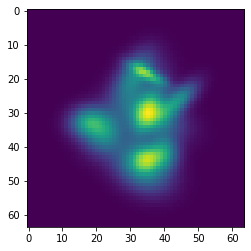

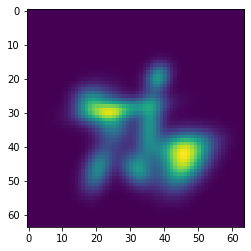

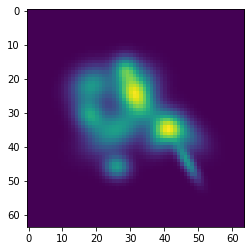

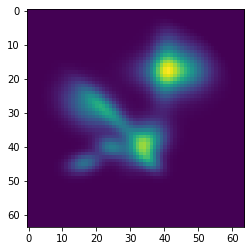

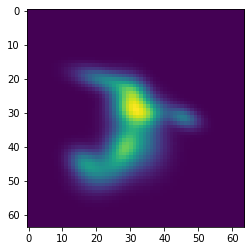

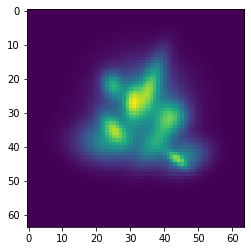

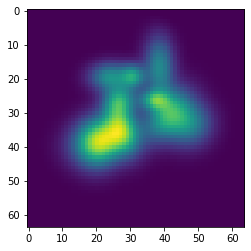

In [14]:
for i in range(10):
    plt.imshow(pictures[i])
    plt.show()

In [15]:
with open(jn(config['dataset']['pic_path'], 'one_piece.npy'), 'wb+') as f:
    np.save(f, pictures)

# counting losses in fibers (input of nerual network)

In [16]:
    size = None
    max_possible_size = config['sim']['max_possible_size']
    test_size = config['sim']['test_size']
    batch_size = config['sim']['batch_size']
    n_del = geo['n_spl']
    mas = np.load(jn(config['dataset']['pic_path'],'one_piece.npy'), mmap_mode='r')
    if size == None:
        size = min(mas.shape[0], max_possible_size)
    if test_size == 'None':
        test_size = int(size / 10)
    mas = mas[0:size]
    mas = mas.astype('float32')

In [17]:
config['sim']['test_mod'] = False
input, output, input_test, output_test = sl.sim_on_gpu(
    mas, test_size, batch_size, config=config,
    seed=seeds[1])  # use random inside

2022-05-28 13:09:47.158393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


# defining nerual network for decoding and fitting it

In [18]:
print('input shape: ', input.shape, '\noutput shape: ', output.shape)

input shape:  (180, 64, 4) 
output shape:  (180, 64, 64)


In [19]:
tr = config['train']
model = sl.SensorNN5S_norm_deep(input.shape, output.shape)
model.build(input.shape)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(tr['lerning_rate']),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model_name = 'SensorNN5S_norm_deep'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 4)]      0           []                               
                                                                                                  
 reshape (Reshape)              (None, 64, 4, 1)     0           ['input_1[0][0]']                
                                                                                                  
 Conv_1.1 (Conv2D)              (None, 64, 4, 8)     32          ['reshape[0][0]']                
                                                                                                  
 MaxPool_1.1 (MaxPooling2D)     (None, 32, 4, 8)     0           ['Conv_1.1[0][0]']               
                                                                                              

In [20]:
# model.fit(dataset_b, epochs=n_epochs, verbose=1)
tf.keras.utils.set_random_seed(seed=int(seeds[2]))  # use random
model.fit(input, output, epochs=tr['n_epochs'], verbose=1)

Epoch 1/20
6/6 [==============================] - 6s 20ms/step - loss: 0.1686 - accuracy: 0.0168
Epoch 2/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1664 - accuracy: 0.0199
Epoch 3/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1639 - accuracy: 0.0208
Epoch 4/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1611 - accuracy: 0.0209
Epoch 5/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1580 - accuracy: 0.0240
Epoch 6/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1543 - accuracy: 0.0240
Epoch 7/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1496 - accuracy: 0.0244
Epoch 8/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1437 - accuracy: 0.0254
Epoch 9/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.0274
Epoch 10/20
6/6 [==============================] - 0s 7ms/step - loss: 0.1251 - accuracy: 0.0282
Epoch 11/20
6/6 [=====================

In [21]:
model.save(jn(tr['models_path'], model_name + '.nn'))

INFO:tensorflow:Assets written to: models/SensorNN5S_norm_deep.nn/assets


INFO:tensorflow:Assets written to: models/SensorNN5S_norm_deep.nn/assets


# evoluate model on don't seen data

In [22]:
model = tf.keras.models.load_model(jn(tr['models_path'], model_name + '.nn'))

In [23]:
model.evaluate(input_test, output_test)

1/1 [==============================] - 0s 264ms/step - loss: 0.0907 - accuracy: 0.0383


[0.09069039672613144, 0.03828125074505806]

In [24]:
predictions = model.predict(input_test)
predictions.shape

1/1 [==============================] - 0s 192ms/step


(20, 64, 64)

# saving resalts

In [25]:
ev = config['evaluate']

In [26]:
with open(jn(ev['pred_path'], 'pred.npy'), 'wb') as f:
    np.save(f, predictions)
with open(jn(ev['pred_path'], 'true.npy'), 'wb') as f:
    np.save(f, output_test)

# look on resalts

In [27]:
with open(jn(ev['pred_path'], 'pred.npy'), 'rb') as f:
    predictions = np.load(f)
with open(jn(ev['pred_path'], 'true.npy'), 'rb') as f:
    output_test = np.load(f)

len=  20


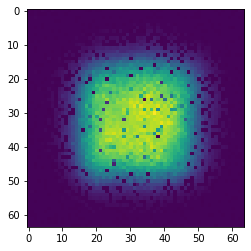

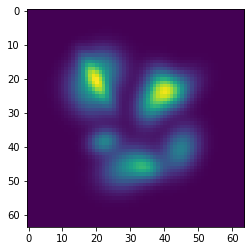

In [29]:
print('len= ', len(predictions))
N = 3 # number of exampel
plt.imshow(predictions[N])
plt.show()
plt.imshow(output_test[N])
plt.show()